In [66]:
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [67]:
#Read in the cleaned data generated by Data_Cleaning. Save that data as a pandas dataframe, df.
df = pd.read_csv('./Cleaned_Data/V_Full_Data_wPCA.csv')

#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 
#Therefore we should multiply the given cycles by 2 to get the true cycle number.
df["cycle number"] = df["cycle number"].apply(lambda x: 2*x)
df["Cycles Until Fail"] = df["Cycles Until Fail"].apply(lambda x: 2*x)#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 

# Adding a classification taget and an additional feature that we can use for regression. 

# Adding a column for the true category (1 if the battery lasts over 200 cycles) (0 otherwise).
to_num=df['label']
to_num=to_num.map({'25C01':1.0,'25C02':0.0,'25C03':0.0,'25C04':0.0,'25C05':0.0,'25C06':0.0,'25C07':0.0,'25C08':0.0,
            '35C01':1.0,'35C02':1.0,'45C01':1.0,'45C02':1.0})
df['category']=to_num

# Adding temperature as a column. 
temdf=df['label']
temdf=temdf.map({'25C01':25.0,'25C02':25.0,'25C03':25.0,'25C04':25.0,'25C05':25.0,'25C06':25.0,'25C07':25.0,
                 '25C08':25.0,'35C01':35.0,'35C02':35.0,'45C01':45.0,'45C02':45.0})
df['temperature']=temdf

df[df['cycle number']==2]

,label,cycle number,Capacity/mA.h,Norm_Cap,Cycles Until Fail,20004.453 Re,15829.126 Re,12516.703 Re,9909.4424 Re,7835.48 Re,...,0.06443 Im,0.05102 Im,0.04042 Im,0.03192 Im,0.02528 Im,0.01999 Im,EIS_PCA_1,EIS_PCA_2,category,temperature
0,25C01,2,37.202713,1.0,234,0.38470,0.39156,0.39684,0.40341,0.40963,...,0.15473,0.18024,0.21535,0.25411,0.29026,0.32795,-0.648439,0.135808,1.0,25.0
261,25C02,2,35.060836,1.0,12,0.27315,0.28005,0.28916,0.29896,0.31009,...,0.16948,0.19432,0.23012,0.27316,0.31468,0.35528,0.997356,-0.606846,0.0,25.0
442,25C03,2,36.771703,1.0,164,0.26859,0.27977,0.28738,0.29862,0.31003,...,0.18334,0.21595,0.25083,0.28522,0.32480,0.37723,1.561054,-0.809891,0.0,25.0
644,25C04,2,35.534219,1.0,114,0.26546,0.27469,0.28046,0.29147,0.30112,...,0.18886,0.21123,0.24230,0.28393,0.32850,0.37336,1.061945,-0.751243,0.0,25.0
679,25C05,2,37.210831,1.0,152,0.34630,0.35399,0.35952,0.36615,0.37339,...,0.15592,0.17752,0.20654,0.23916,0.27151,0.31109,-1.097987,-0.006821,0.0,25.0
954,25C06,2,35.992184,1.0,120,0.29226,0.29988,0.30750,0.31758,0.32662,...,0.17112,0.19462,0.22959,0.27546,0.32275,0.36648,0.706666,-0.459589,0.0,25.0
1166,25C07,2,35.684646,1.0,32,0.30065,0.30717,0.31678,0.32634,0.33815,...,0.17637,0.20248,0.24127,0.28804,0.33312,0.37771,1.237057,-0.580435,0.0,25.0
1306,25C08,2,33.943672,1.0,32,0.28914,0.29589,0.30454,0.31619,0.32735,...,0.18095,0.20767,0.24267,0.28048,0.32001,0.37131,1.384369,-0.730253,0.0,25.0
1343,35C01,2,40.113305,1.0,218,0.27500,0.28167,0.28649,0.29203,0.29889,...,0.14148,0.15970,0.18417,0.21406,0.24424,0.27584,-2.642164,-0.091726,1.0,35.0
1670,35C02,2,40.473768,1.0,262,0.47084,0.47585,0.48147,0.48775,0.49372,...,0.13944,0.15736,0.18120,0.21156,0.24130,0.27295,-1.313667,0.634642,1.0,35.0


In [68]:
#Generate smaller, balanced dataframes with information from only early cycles. 

#Generate a dataframe with the first 20 cycles only
df_20 = df[(df['cycle number']<=20)]

#Generate a dataframe with the first 40 cycles only
df_40 = df[(df['cycle number']<=40)]

In [150]:
#Functions to run Lasso and generate plots. 
def run_Classification_ML(df,Train_L,Test_L,feats,model):
    feature_names=feats
    train_df = pd.DataFrame(columns = df.columns)
    for Label in Train_L:
            selected_rows = df[df['label'] == Label]
            train_df = pd.concat([train_df,selected_rows],ignore_index=True) 
    X_train = train_df[feature_names]
    y_train = train_df['category']
    
    test_df = pd.DataFrame(columns = df.columns)
    for Label in Test_L:
        #Get the correct train test splits. 
        selected_rows = df[df['label'] == Label]
        test_df = pd.concat([test_df,selected_rows],ignore_index=True) 
    X_test = test_df[feature_names]
    y_test = test_df['category']
    #Running the Model
    clf = model
    clf.fit(X_train, y_train)
    clf_pred=clf.predict(X_test)   
    return y_test.to_list(),clf_pred,clf
        
    
def Train_Regr_ML(df,Train_L,model,feats):
    train_df = pd.DataFrame(columns = df.columns)
    for Label in Train_L:
            selected_rows = df[(df['label'] == Label)]
            train_df = pd.concat([train_df,selected_rows],ignore_index=True) 
    X_train = train_df[feats]
    y_train = train_df['Cycles Until Fail']
    
    #Running the Model
    regr = model
    regr.fit(X_train, y_train)
    
    #Return the trained model.
    return regr
    
#For testing batteries one at a time. 
def Test_Regr_Model(df,Test_Label,regr,feats):
    test_df = pd.DataFrame(columns = df.columns)
    selected_rows = df[(df['label'] == Test_Label)]
    test_df = pd.concat([test_df,selected_rows],ignore_index=True) 
    X_test = test_df[feats]
    y_test = test_df['Cycles Until Fail']
    #Convert y_test to numpy and rename
    true_C=y_test.to_numpy() 
    
    #Predict using the trained model
    regr_pred=regr.predict(X_test)
    
    #Return the predictions and the true values
    return regr_pred,true_C
    
def add_cycling(Pred,TruC):
    TotalP=[]
    TotalT=[]
    for i in range(len(Pred)):
        LP=np.arange(Pred[i],0,-1)
        LT=np.arange(TruC[i],TruC[i]-len(LP),-1)
        TotalP.append(LP)
        TotalT.append(LT)
    return TotalP,TotalT
        
    
def make_Cycling_Plots(Pred,TruC,label):
    title_string=str(label)+'Predicted Cycle to Failure vs True Cycles to Failure'
    TotalP,TotalT=add_cycling(Pred,TruC)
    xref=np.arange(0,TotalT[0][0],1)
    cerr=np.arange(0,len(TotalP),1)
    N=len(TotalP)
    cmap=plt.get_cmap('viridis',N)
    for i in range(len(TotalP)):
        plt.plot(TotalT[i],TotalP[i],c=cmap(i),alpha=0.8,linewidth=3.0)
    norm=mpl.colors.Normalize(vmin=2,vmax=2*len(TotalP))
    sm=plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))
    cbar.set_label('Index')
    plt.plot(xref,xref,'k',linestyle='dashed',linewidth=3)
    plt.title(title_string)
    plt.xlabel('True # of Cycles until Failure')
    plt.ylabel('Predicted # of Cycles until Failure')
    plt.show()
    

['20004.453 Im' '8.81772 Im' 'temperature']
[-2139.96935639  -318.65034428     9.51399186]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 140.26585233805088
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


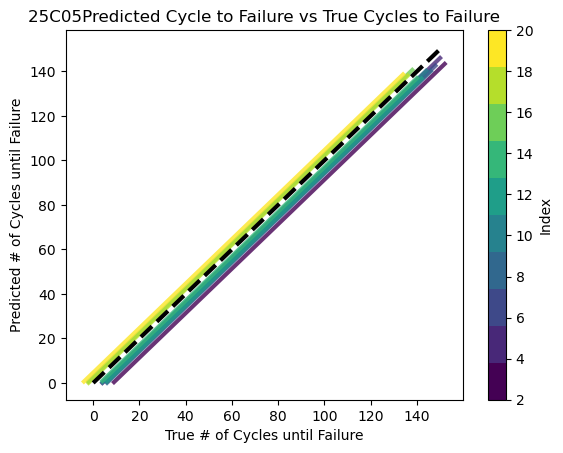

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 84.86211132158996
The True RuL at Cycle 10 is: 112


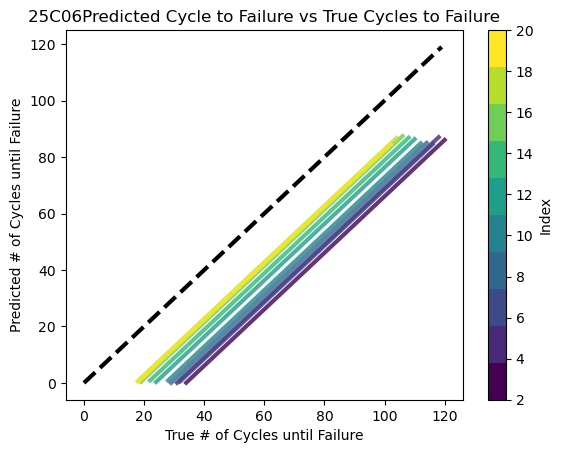

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 62.35757089481595
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


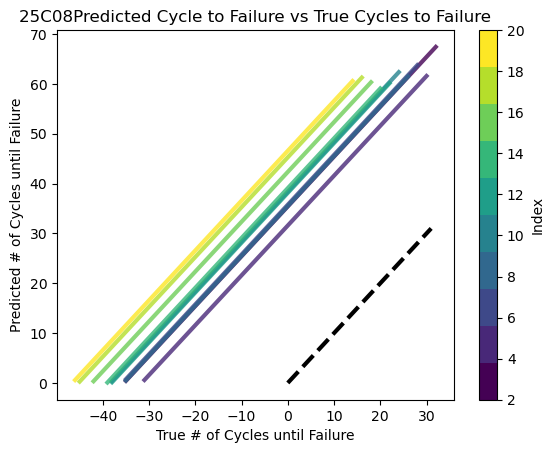

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 35C02 The Predicted RuL at Cycle 10 is: 252.59807432413913
The True RuL at Cycle 10 is: 254


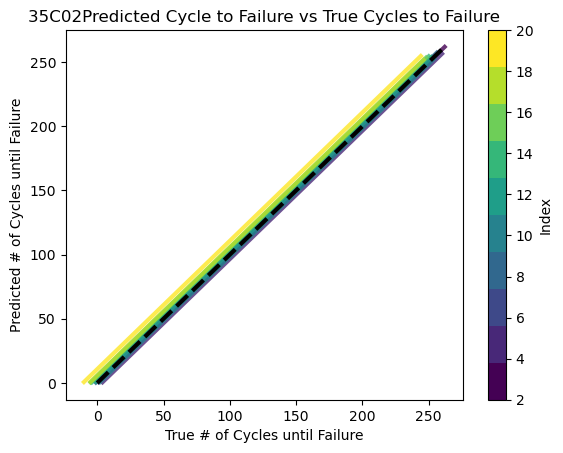

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 377.57876631606723
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/798541319.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


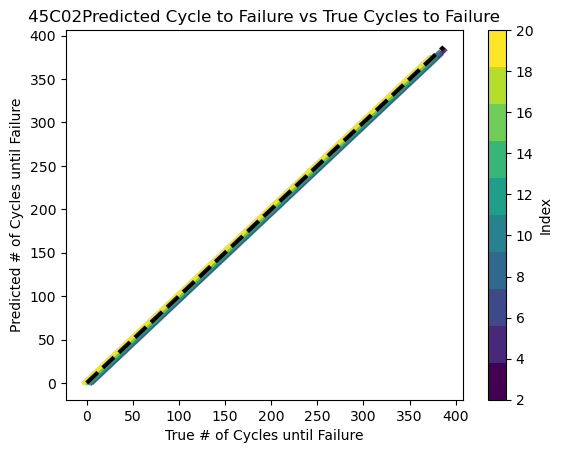

In [151]:
###
### First 40 cycles
### 20kHz and 8.8Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','8.81772 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.05,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

['20004.453 Im' 'temperature']
[-3419.98585773    11.79699506]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 116.40093241905174
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


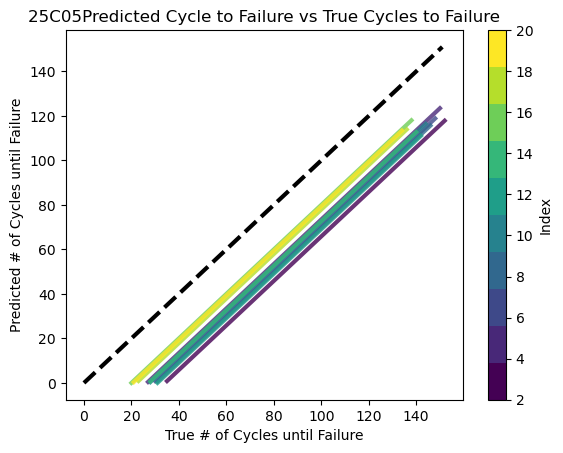

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 75.73730057069406
The True RuL at Cycle 10 is: 112


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


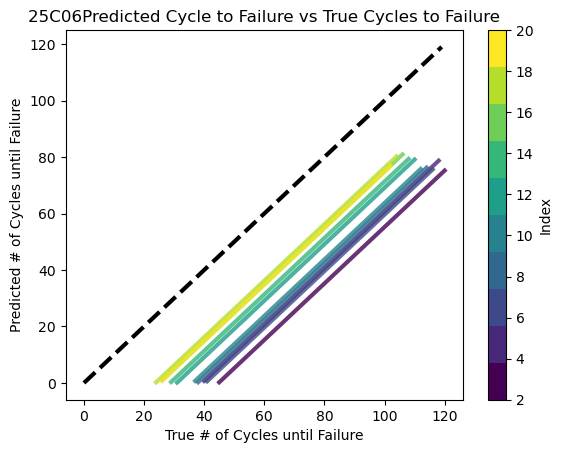

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C08 The Predicted RuL at Cycle 10 is: 71.70171725857784
The True RuL at Cycle 10 is: 24


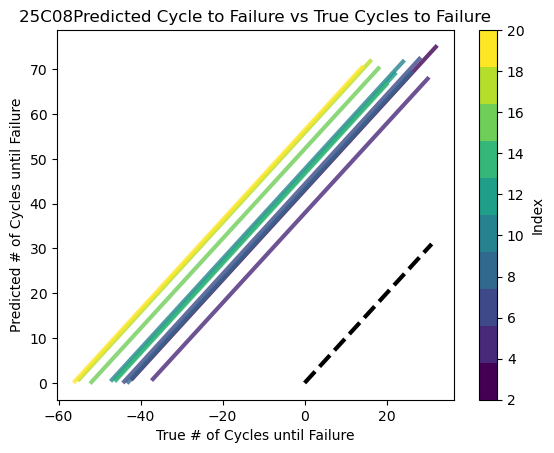

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 232.52409067432632
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


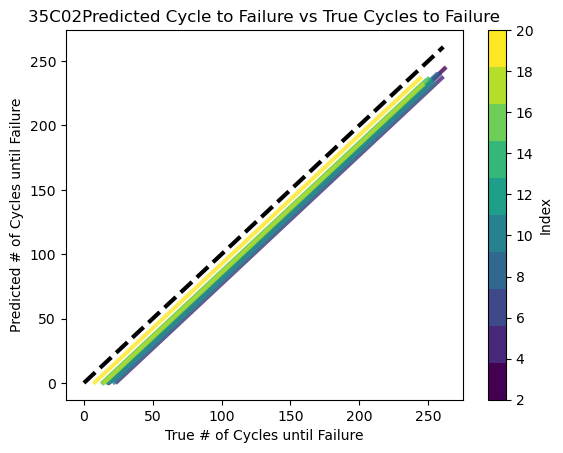

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 45C02 The Predicted RuL at Cycle 10 is: 384.93329888006986
The True RuL at Cycle 10 is: 380


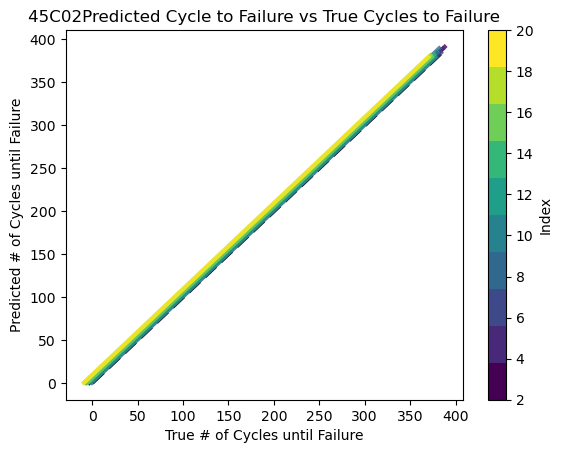

In [90]:
###
### First 40 cycles
### Only 20kHz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

['0.03192 Im' 'temperature']
[-762.44461739   11.07106135]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 120.37243138282034
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


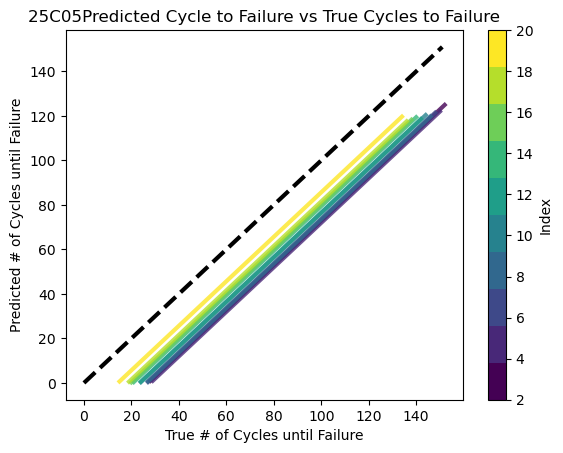

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 97.90318850848394
The True RuL at Cycle 10 is: 112


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


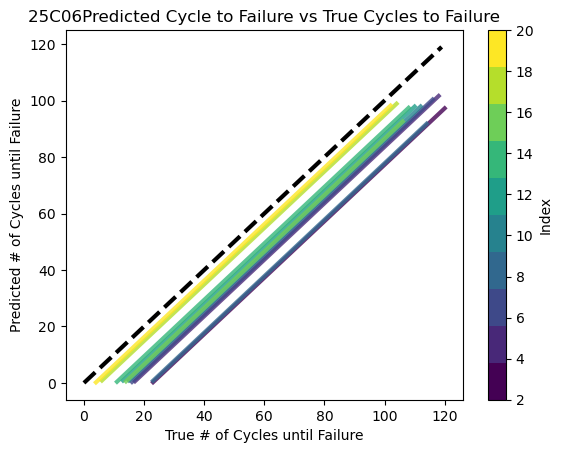

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 86.68000374057655
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


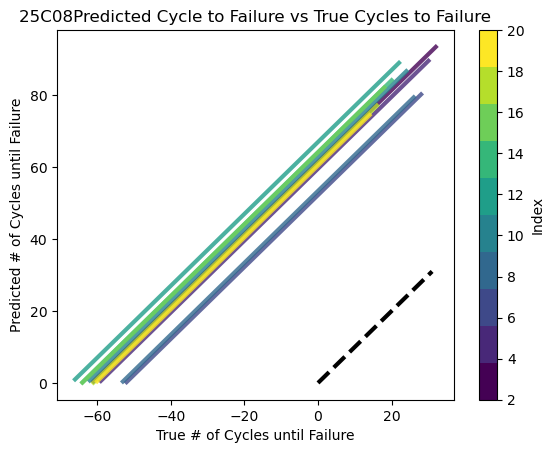

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 252.67547640952722
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


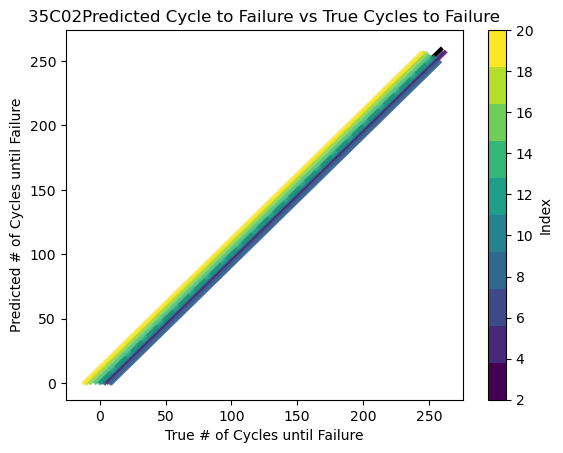

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 379.1915667902819
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


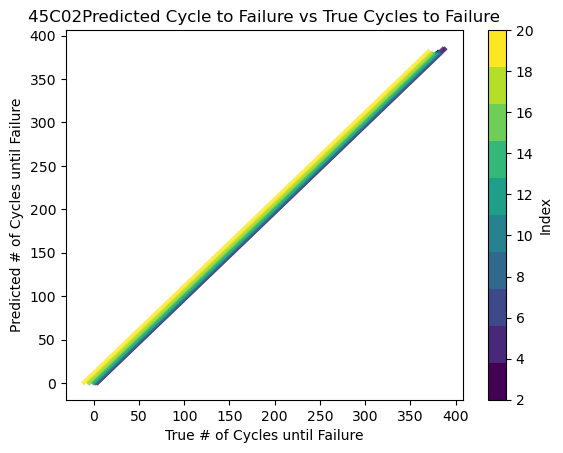

In [98]:
###
### First 40 cycles
### Only 0.03Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['0.03192 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

['3070.9827 Im' '8.81772 Im' '0.03192 Im' 'temperature']
[-3758.015033      -0.          1392.51950394     9.82540758]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 160.34401082384022
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


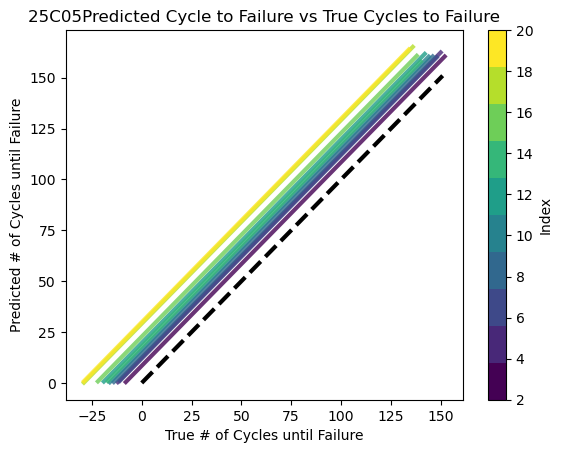

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 74.21033188796497
The True RuL at Cycle 10 is: 112


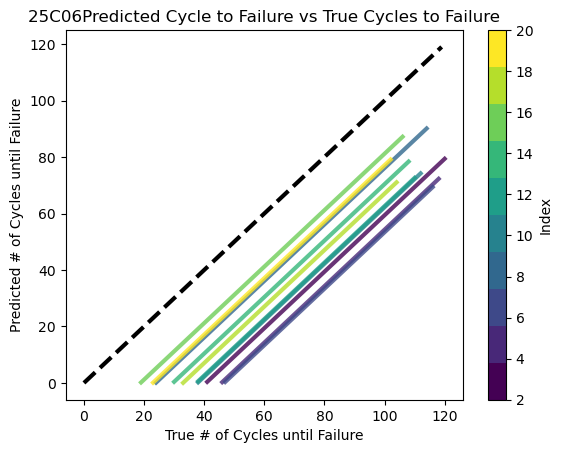

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 87.19218891988834
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


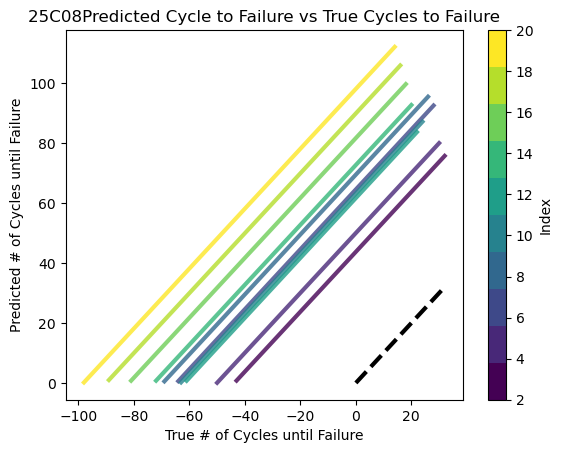

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 255.50193963576135
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


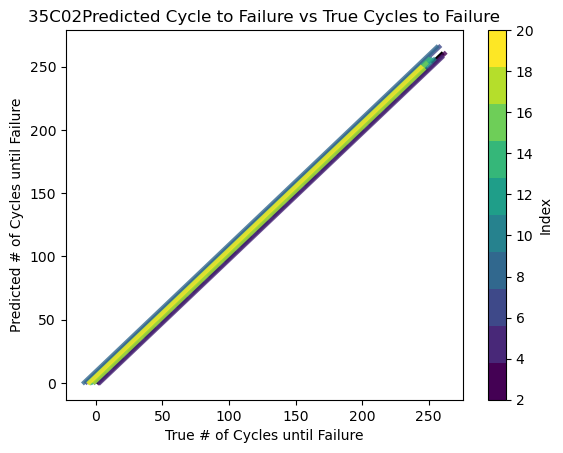

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 377.5764568761208
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


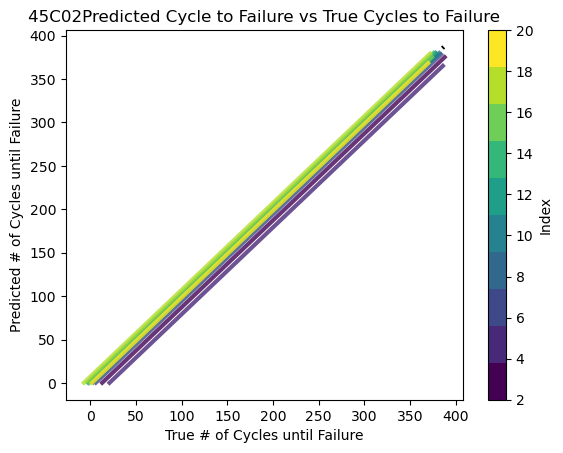

In [110]:
###
### First 40 cycles
### Only 0.03Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['3070.9827 Im','8.81772 Im','0.03192 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

['20004.453 Im' '0.03192 Im' 'temperature']
[-4093.8381251    150.6312692     11.94221013]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 115.60446980595174
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


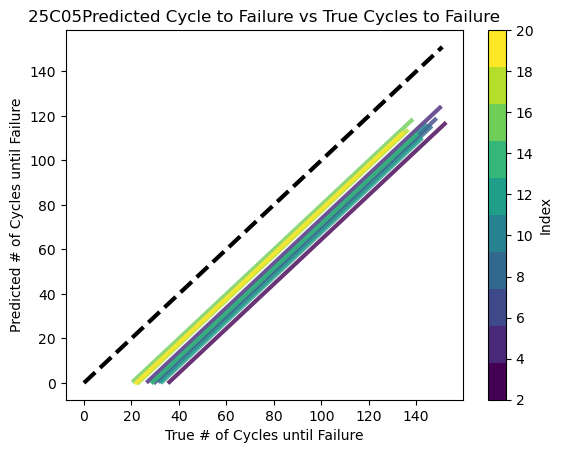

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 71.36783800193177
The True RuL at Cycle 10 is: 112


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


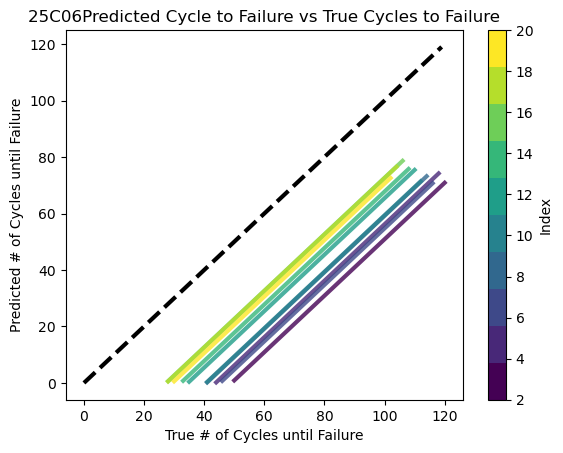

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C08 The Predicted RuL at Cycle 10 is: 68.75440129699854
The True RuL at Cycle 10 is: 24


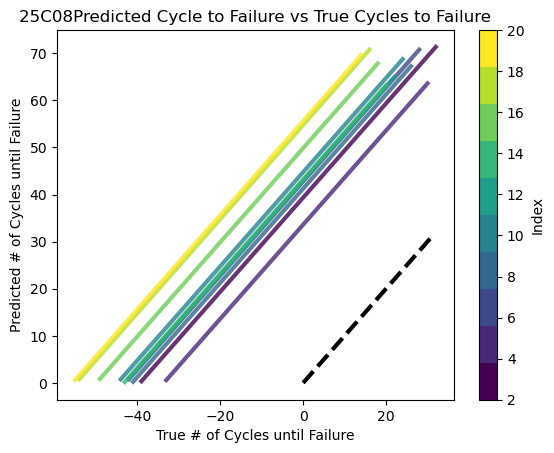

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 228.55002093461866
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


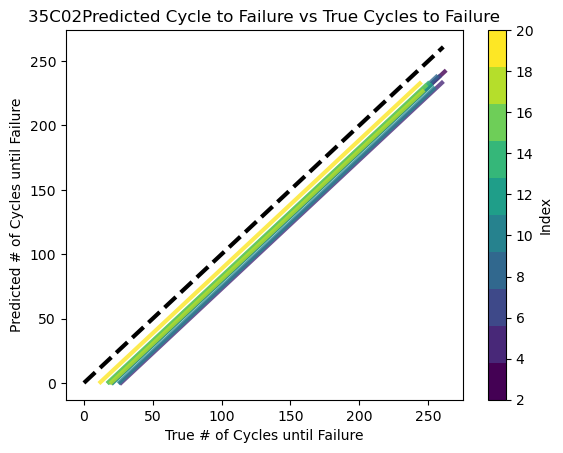

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 386.07448590388725
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


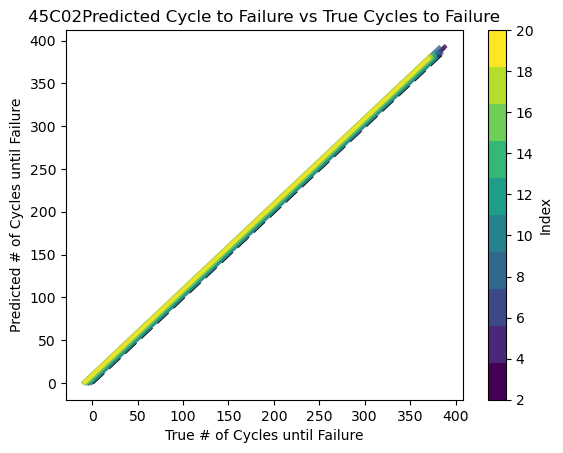

In [149]:
#
###
### First 40 cycles
### Only 0.03Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','0.03192 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.08,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

['17.79613 Im' '2.16054 Im' 'temperature']
[-1646.19630793  1065.10377283     4.29279804]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 162.53640306046833
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


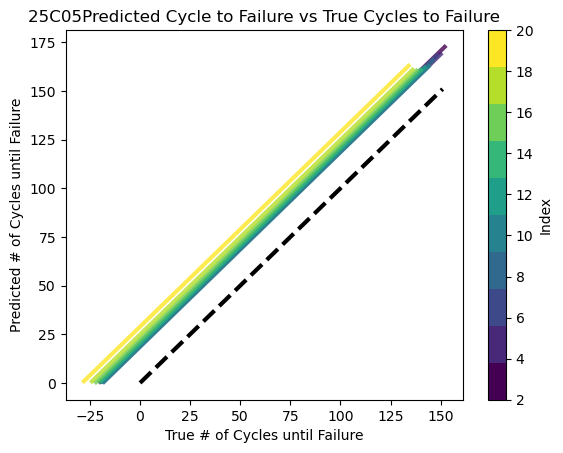

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 64.7986109921589
The True RuL at Cycle 10 is: 112


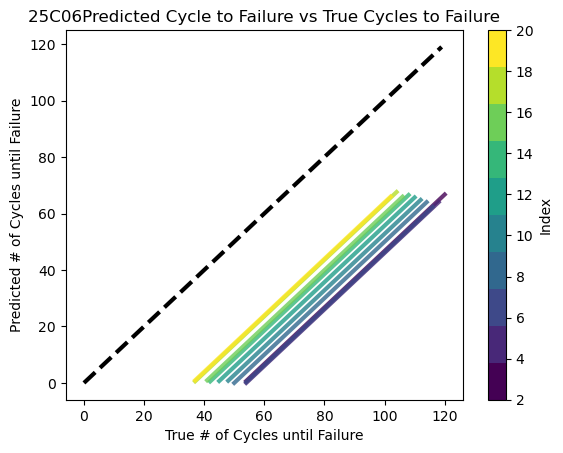

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 106.05484683215116
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


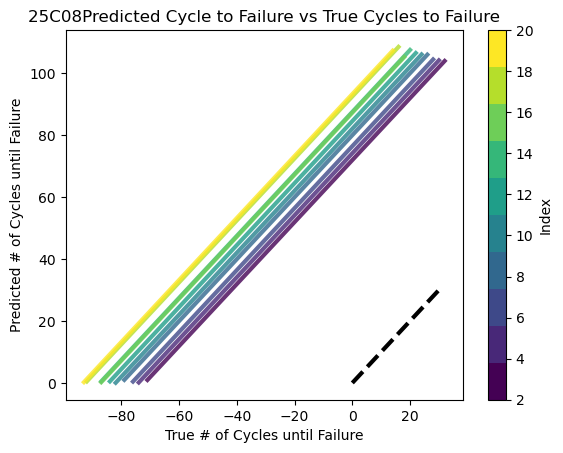

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 280.6706602015946
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


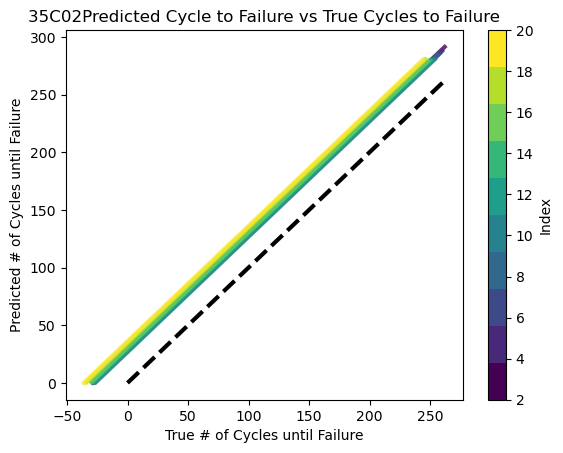

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 371.67714728294914
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


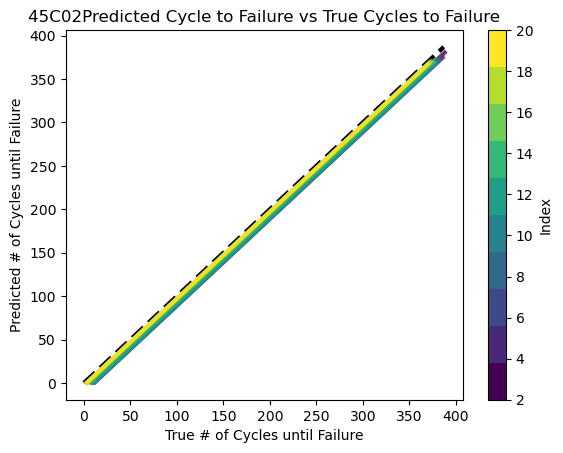

In [128]:
###
### First 40 cycles
### Only 0.03Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['17.79613 Im','2.16054 Im','temperature']
#feats1=['20004.453 Im','8.81772 Im','0.03192 Im']
mydf=df_20

model = Lasso(alpha=0.2,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

['17.79613 Im' '2.16054 Im']
[-2296.33029863  1577.73547593]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 186.28029504286866
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


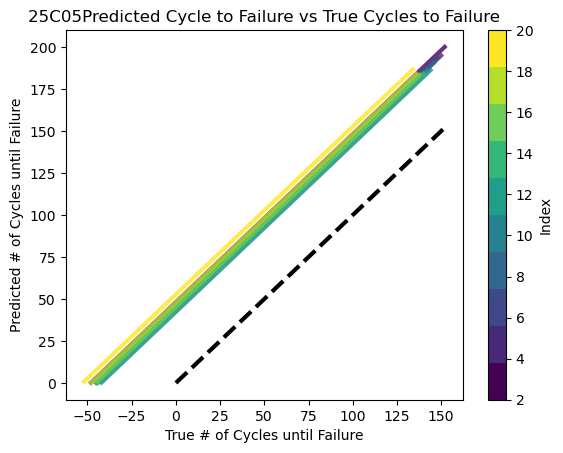

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 54.5220382860154
The True RuL at Cycle 10 is: 112


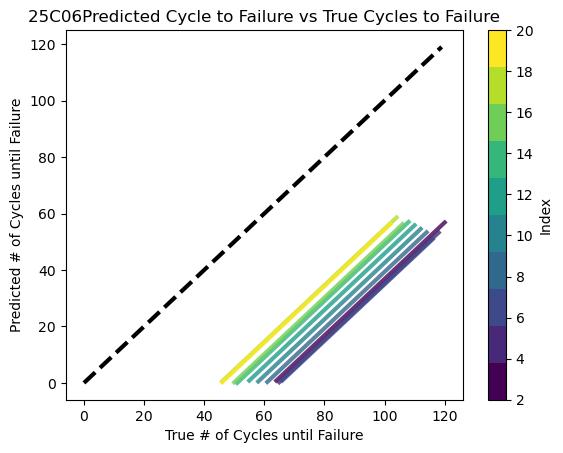

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 118.97450968474345
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


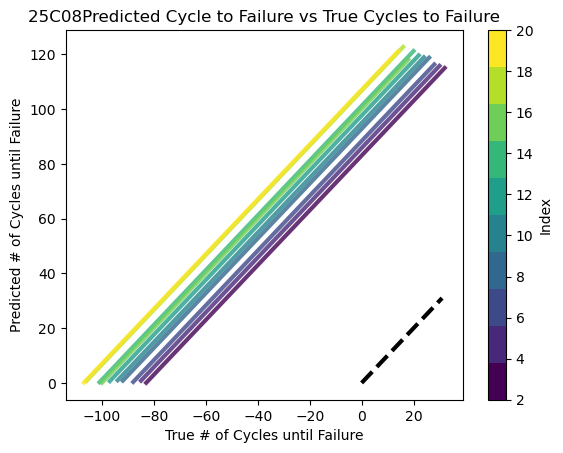

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 35C02 The Predicted RuL at Cycle 10 is: 288.70047604121817
The True RuL at Cycle 10 is: 254


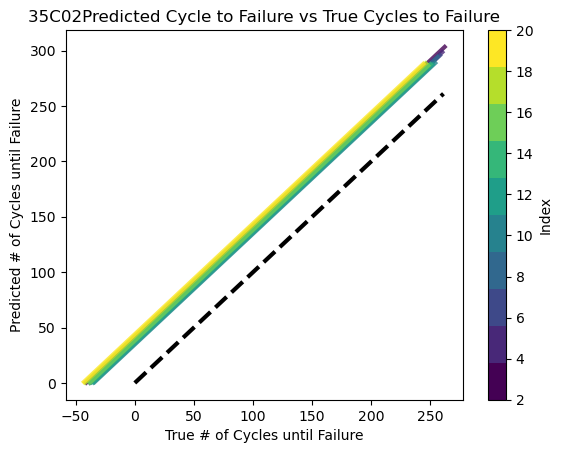

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 354.8035497529521
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_69482/1832686752.py:80: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


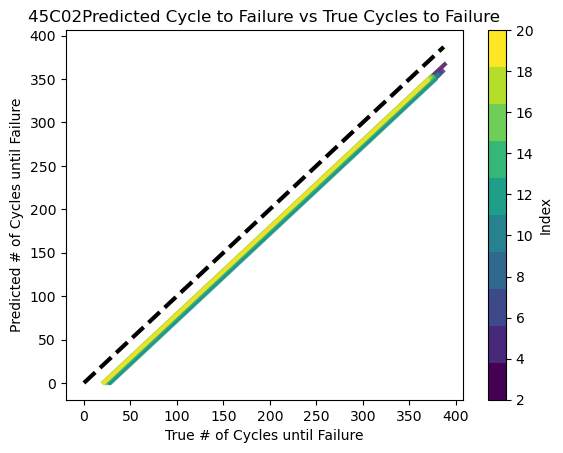

In [129]:
###
### First 40 cycles
### Only 0.03Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['17.79613 Im','2.16054 Im']
#feats1=['20004.453 Im','8.81772 Im','0.03192 Im']
mydf=df_20

model = Lasso(alpha=0.2,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

In [126]:
#df_20.columns.to_list()[65:125]

In [155]:
df_20[['label','cycle number']]

,label,cycle number
0,25C01,2
1,25C01,4
2,25C01,6
3,25C01,8
4,25C01,10
...,...,...
2292,45C02,12
2293,45C02,14
2294,45C02,16
2295,45C02,18
